# Gallery for DR6

The purpose of this notebook is to build the gallery for the sixth Legacy Survey data release, DR6.  The theme of this gallery is...the NGC catalog!

For future reference: The notebook must be run from https://jupyter-dev.nersc.gov with the following (approximate) activation script:
```bash
#!/bin/bash                                                                                                           
version=$1                                                                                                            
connection_file=$2                                                                                                    
                                                                                                                      
desiconda_version=20170818-1.1.12-img                                                                                 
module use /global/common/${NERSC_HOST}/contrib/desi/desiconda/$desiconda_version/modulefiles                         
module load desiconda                                                                                                 
                                                                                                                      
export LEGACY_SURVEY_DIR=/global/cscratch1/sd/dstn/dr6plus                                                            
export LEGACYPIPE_DIR=$SCRATCH/repos/legacypipe                                                                       
                                                                                                                      
export PATH=$LEGACYPIPE_DIR/bin:${PATH}                                                                               
export PATH=$SCRATCH//repos/build/bin:$PATH                                                                           
export PYTHONPATH=$LEGACYPIPE_DIR/py:${PYTHONPATH}                                                                    
export PYTHONPATH=$SCRATCH/repos/build/lib/python3.5/site-packages:$PYTHONPATH                                        
                                                                                                                      
module use $LEGACYPIPE_DIR/bin/modulefiles/cori                                                                       
module load dust                                                                                                      
                                                                                                                      
exec python -m ipykernel -f $connection_file                                                                          
```

### Imports and paths

In [1]:
import os, sys
import shutil, time, warnings
from contextlib import redirect_stdout
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, Column, vstack
from astropy.io import ascii
from PIL import Image, ImageDraw, ImageFont
#from astrometry.util.starutil_numpy import hmsstring2ra

In [3]:
from astrometry.util.util import Tan
from astrometry.util.fits import merge_tables
from legacypipe.survey import LegacySurveyData
from legacypipe.runbrick import run_brick

In [4]:
import multiprocessing
nproc = multiprocessing.cpu_count() // 2

In [5]:
%matplotlib inline

### Preliminaries

Define the data release and the various output directories.

In [6]:
dr = 'dr6'
PIXSCALE = 0.262

In [7]:
gallerydir = os.path.join( os.getenv('SCRATCH'), dr, 'gallery' )
galleryfile = os.path.join(gallerydir, 'gallery-{}.fits'.format(dr))

In [8]:
jpgdir = os.path.join(gallerydir, 'jpg')
if not os.path.isdir(jpgdir):
    os.mkdir(jpgdir)

In [9]:
pngdir = os.path.join(gallerydir, 'png')
if not os.path.isdir(pngdir):
    os.mkdir(pngdir)

#### Read the Open NGC catalog created by Mattia Verga:
https://github.com/mattiaverga/OpenNGC

```bash
wget https://raw.githubusercontent.com/mattiaverga/OpenNGC/master/NGC.csv
```

- Name: Object name composed by catalog + number
    NGC: New General Catalogue
    IC: Index Catalogue
    
- Type: Object type
  - *: Star
  - **: Double star
  - *Ass: Association of stars
  - OCl: Open Cluster
  - GCl: Globular Cluster
  - Cl+N: Star cluster + Nebula
  - G: Galaxy
  - GPair: Galaxy Pair
  - GTrpl: Galaxy Triplet
  - GGroup: Group of galaxies
  - PN: Planetary Nebula
  - HII: HII Ionized region
  - DrkN: Dark Nebula
  - EmN: Emission Nebula
  - Neb: Nebula
  - RfN: Reflection Nebula
  - SNR: Supernova remnant
  - Nova: Nova star
  - NonEx: Nonexistent object
    
- RA: Right Ascension in J2000 Epoch (HH:MM:SS.SS)

- Dec: Declination in J2000 Epoch (+/-DD:MM:SS.SS)

- Const: Constellation where the object is located

- MajAx: Major axis, expressed in arcmin

- MinAx: Minor axis, expressed in arcmin

- PosAng: Major axis position angle (North Eastwards)

- B-Mag: Apparent total magnitude in B filter

- V-Mag: Apparent total magnitude in V filter

- J-Mag: Apparent total magnitude in J filter

- H-Mag: Apparent total magnitude in H filter

- K-Mag: Apparent total magnitude in K filter

- SurfBr (only Galaxies): Mean surface brigthness within 25 mag isophot (B-band), expressed in mag/arcsec2

- Hubble (only Galaxies): Morphological type (for galaxies)

- Cstar U-Mag (only Planetary Nebulae): Apparent magnitude of central star in U filter

- Cstar B-Mag (only Planetary Nebulae): Apparent magnitude of central star in B filter

- Cstar V-Mag (only Planetary Nebulae): Apparent magnitude of central star in V filter

- M: cross reference Messier number

- NGC: other NGC identification, if the object is listed twice in the catalog

- IC: cross reference IC number, if the object is also listed with that identification

- Cstar Names (only Planetary Nebulae): central star identifications

- Identifiers: cross reference with other catalogs

- Common names: Common names of the object if any

- NED Notes: notes about object exported from NED

- OpenNGC Notes: notes about the object data from OpenNGC catalog


In [10]:
names = ('name', 'type', 'ra_hms', 'dec_dms', 'const', 'majax', 'minax', 
         'pa', 'bmag', 'vmag', 'jmag', 'hmag', 'kmag', 'sbrightn', 'hubble', 
         'cstarumag', 'cstarbmag', 'cstarvmag', 'messier', 'ngc', 'ic', 
         'cstarnames', 'identifiers', 'commonnames', 'nednotes', 'ongcnotes')

In [11]:
NGC = ascii.read(os.path.join(gallerydir, 'NGC.csv'), delimiter=';', names=names)
NGC.write(os.path.join(gallerydir, 'NGC.fits'), overwrite=True)
NGC

name,type,ra_hms,dec_dms,const,majax,minax,pa,bmag,vmag,jmag,hmag,kmag,sbrightn,hubble,cstarumag,cstarbmag,cstarvmag,messier,ngc,ic,cstarnames,identifiers,commonnames,nednotes,ongcnotes
str13,str6,str11,str11,str3,float64,float64,int64,float64,float64,float64,float64,float64,float64,str4,float64,float64,float64,int64,str10,str14,str51,str211,str56,str80,str97
IC0002,G,00:11:00.88,-12:49:22.3,Cet,0.98,0.32,142,15.46,--,12.26,11.48,11.17,23.45,Sb,--,--,--,--,--,--,--,"2MASX J00110081-1249206,IRAS 00084-1306,MCG -02-01-031,PGC 000778",--,--,B-Mag taken from LEDA.
IC0003,G,00:12:06.09,-00:24:54.8,Psc,0.93,0.67,53,15.1,--,11.53,10.79,10.54,23.5,E,--,--,--,--,--,--,--,"2MASX J00120604-0024543,MCG +00-01-038,PGC 000836,SDSS J001206.08-002454.7,SDSS J001206.09-002454.7,SDSS J001206.09-002454.8,SDSS J001206.10-002454.8",--,--,--
IC0004,G,00:13:26.94,+17:29:11.2,Peg,1.17,0.84,12,14.2,--,11.51,10.65,10.5,23.01,Sc,--,--,--,--,--,--,--,"2MASX J00132695+1729111,IRAS 00108+1712,MCG +03-01-029,PGC 000897,UGC 00123",--,--,--
IC0005,G,00:17:34.93,-09:32:36.1,Cet,0.99,0.66,9,14.57,--,11.5,10.85,10.5,23.4,E,--,--,--,--,--,--,--,"2MASX J00173495-0932364,MCG -02-01-047,PGC 001145,SDSS J001734.93-093236.0,SDSS J001734.93-093236.1",--,--,B-Mag taken from LEDA.
IC0006,G,00:18:55.04,-03:16:33.9,Psc,1.23,1.08,146,14.5,--,11.03,10.32,10.08,23.89,E,--,--,--,--,--,--,--,"2MASX J00185505-0316339,MCG -01-01-075,PGC 001228",--,--,--
IC0007,G,00:18:53.16,+10:35:40.9,Psc,0.9,0.63,174,14.7,--,11.33,10.57,10.26,23.22,S0,--,--,--,--,--,--,--,"2MASX J00185316+1035410,PGC 001216",--,--,--
IC0008,G,00:19:02.72,-03:13:19.5,Psc,0.82,0.34,129,15.16,--,12.7,12.08,12.08,23.4,E?,--,--,--,--,--,--,--,"2MASX J00190272-0313196,MCG -01-01-076,PGC 001234",--,--,B-Mag taken from LEDA.
IC0009,G,00:19:43.98,-14:07:18.8,Cet,0.59,0.46,122,15.41,--,12.38,11.71,11.28,22.88,Sa,--,--,--,--,--,--,--,"2MASX J00194400-1407184,MCG -02-02-001,PGC 001271",--,--,B-Mag taken from LEDA.
IC0010,G,00:20:17.34,+59:18:13.6,Cas,6.76,6.03,129,13.6,9.5,7.23,6.34,6.01,24.53,IB,--,--,--,--,--,--,--,"2MASX J00201733+5918136,IRAS 00175+5902,IRAS 00177+5900,MCG +10-01-001,PGC 001305,UGC 00192",--,The 2MASX position refers to the center of the IR isophotes.,--


#### Select the desired object types.

Here we choose ...

In [12]:
majax = ma.getdata(NGC['majax']) # arcmin
objtype = np.char.strip(ma.getdata(NGC['type']))

In [13]:
keeptype = ('G', 'PN', 'OCl', 'GCl', 'Cl+N') # Cl gives us GCl, OCl, and Cl+N
#keeptype = ('G', 'GPair', 'GTrpl', 'GGroup', 'PN', 'Cl') # Cl gives us GCl, OCl, and Cl+N
keep = np.zeros(len(NGC), dtype=bool)
for otype in keeptype:
    print('Working on {}'.format(otype))
    ww = [otype == tt for tt in objtype]
    keep = np.logical_or(keep, ww)

Working on G
Working on PN
Working on OCl
Working on GCl
Working on Cl+N


#### Require "big" objects, particularly the galaxies (to cut down the sample size).

In [14]:
galtoss = (objtype == 'G') * (majax < 3)
keep = np.logical_and(keep, (majax > 0.3) * (majax < 20))
keep = np.logical_and(keep, ~galtoss)

In [15]:
nobj = np.count_nonzero(keep)
print('Keeping {} / {} objects'.format(nobj, len(NGC)))
cat = NGC[keep]
cat

Keeping 1676 / 13953 objects


name,type,ra_hms,dec_dms,const,majax,minax,pa,bmag,vmag,jmag,hmag,kmag,sbrightn,hubble,cstarumag,cstarbmag,cstarvmag,messier,ngc,ic,cstarnames,identifiers,commonnames,nednotes,ongcnotes
str13,str6,str11,str11,str3,float64,float64,int64,float64,float64,float64,float64,float64,float64,str4,float64,float64,float64,int64,str10,str14,str51,str211,str56,str80,str97
IC0010,G,00:20:17.34,+59:18:13.6,Cas,6.76,6.03,129,13.6,9.5,7.23,6.34,6.01,24.53,IB,--,--,--,--,--,--,--,"2MASX J00201733+5918136,IRAS 00175+5902,IRAS 00177+5900,MCG +10-01-001,PGC 001305,UGC 00192",--,The 2MASX position refers to the center of the IR isophotes.,--
IC0166,OCl,01:52:23.82,+61:51:09.4,Cas,7.5,--,--,13.0,11.7,--,--,--,--,--,--,--,--,--,--,--,--,MWSC 0146,--,--,--
IC0239,G,02:36:27.88,+38:58:11.7,And,4.25,4.01,75,12.1,--,9.54,9.09,8.78,23.72,SABc,--,--,--,--,--,--,--,"2MASX J02362783+3858085,IRAS 02333+3845,MCG +06-06-065,PGC 009899,UGC 02080",--,--,--
IC0284,G,03:06:09.91,+42:22:18.9,Per,4.29,2.15,14,13.8,--,10.03,9.81,9.28,23.82,Sd,--,--,--,--,--,--,--,"2MASX J03060989+4222189,IRAS 03029+4211,MCG +07-07-023,PGC 011643,UGC 02531",--,--,--
IC0289,PN,03:10:19.26,+61:19:00.4,Cas,0.58,--,--,16.8,--,15.59,15.62,15.14,--,--,--,15.1,15.9,--,--,--,--,"IRAS 03062+6107,PK 138+02 1,PN G138.8+02.8",--,--,--
IC0342,G,03:46:48.50,+68:05:46.9,Cam,19.77,18.79,0,10.5,--,5.66,5.01,4.56,24.85,SABc,--,--,--,--,--,--,--,"2MASX J03464851+6805459,C5,IRAS 03419+6756,MCG +11-05-003,PGC 013826,UGC 02847",--,--,--
IC0348,Cl+N,03:44:34.19,+32:09:46.2,Per,10.0,10.0,--,--,--,--,--,--,--,--,--,--,--,--,--,1985,--,"BD +31 0643,HIP 017465,LBN 758,MWSC 0301",omi Per Cloud,--,--
IC0356,G,04:07:46.91,+69:48:44.8,Cam,4.02,3.73,90,13.3,--,7.16,6.33,6.04,23.27,Sb,--,--,--,--,--,--,--,"2MASX J04074690+6948447,IRAS 04025+6940,MCG +12-04-011,PGC 014508,UGC 02953",--,--,--
IC0361,OCl,04:18:50.70,+58:14:58.2,Cam,7.2,--,--,12.92,11.7,--,--,--,--,--,--,--,--,--,--,--,--,MWSC 0362,--,--,--


In [16]:
print(np.unique(ma.getdata(cat['type'])))
print(np.unique(ma.getdata(cat['hubble'])))

['Cl+N' 'G' 'GCl' 'OCl' 'PN']
['0' 'E' 'E-S0' 'I' 'IAB' 'IB' 'S0' 'S0-a' 'S?' 'SABa' 'SABb' 'SABc' 'SABd'
 'SABm' 'SBa' 'SBab' 'SBb' 'SBbc' 'SBc' 'SBcd' 'SBd' 'SBm' 'Sa' 'Sab' 'Sb'
 'Sbc' 'Sc' 'Scd' 'Sd' 'Sm']


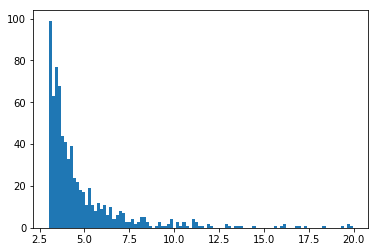

In [17]:
ww = (cat['type'] == 'G')
_ = plt.hist(cat['majax'][ww], bins=100)

#### Convert coordinates in decimal degrees.

In [18]:
coord = SkyCoord(ra=cat['ra_hms'], dec=cat['dec_dms'], unit=(u.hourangle, u.deg))
cat.add_column(Column(name='ra', unit='deg', length=nobj))
cat.add_column(Column(name='dec', unit='deg', length=nobj))
cat['ra'] = coord.ra.value
cat['dec'] = coord.dec.value

### Generate (find) the sample of objects in the DR6 footprint.

In [19]:
survey = LegacySurveyData()
survey.output_dir = gallerydir

In [20]:
def get_name(cat, nice=False):
    name = np.atleast_1d(ma.getdata(cat['name']))
    mess = np.atleast_1d(ma.getdata(cat['messier']))
    comm = np.atleast_1d(ma.getdata(cat['commonnames']))

    outname = []
    if nice:
        hubble_type = np.empty_like(name)
        for nn, mm, cc in zip(name, mess, comm):
            oo = nn.strip().replace('NED01', '').upper()
            if mm != 0:
                oo = '{} = M{}'.format(oo, mm)
            if cc != 0:
                oo = '{} = {}'.format(oo, str(cc).replace(',', ' = '))
            outname.append(oo)
    else:
        for nn in name:
            outname.append(nn.strip().replace(' ', '_').lower())
            
    if len(outname) == 1:
        outname = outname[0]
    return outname

In [21]:
def simple_wcs(obj, diam):
    """Build a simple WCS object for a single object."""
    size = np.rint(diam / PIXSCALE).astype('int') # [pixels]
    wcs = Tan(obj['ra'], obj['dec'], size/2+0.5, size/2+0.5,
                 -PIXSCALE/3600.0, 0.0, 0.0, PIXSCALE/3600.0, 
                 float(size), float(size))
    return wcs

In [22]:
def _build_sample_one(args):
    """Wrapper function for the multiprocessing."""
    return build_sample_one(*args)

In [23]:
def build_sample_one(obj, factor=0.5, verbose=False):
    """Wrapper function to find overlapping grz CCDs for a given object.
    
    """
    name = get_name(obj)
    print('Working on {}...'.format(name))
    diam = factor * ma.getdata(obj['majax']) * 60.0 # diameter [arcsec]
    wcs = simple_wcs(obj, diam)
    try:
        ccds = survey.ccds_touching_wcs(wcs) # , ccdrad=2*diam/3600)
    except:
        return None
    
    if ccds:
        # Is there 3-band coverage?
        if 'g' in ccds.filter and 'r' in ccds.filter and 'z' in ccds.filter:
            if verbose:
                print('For {} (type={}) found {} CCDs, RA = {:.5f}, Dec = {:.5f}, Diameter={:.4f} arcmin'.format(
                        obj['name'], obj['type'], len(ccds), obj['ra'], obj['dec'], obj['majax']))
            return obj
    return None

In [24]:
def build_sample(cat, factor=1.0):
    """Build the full sample with grz coverage in DR6."""

    sampleargs = list()
    for cc in cat:
        sampleargs.append( (cc, factor, True) ) # the False refers to verbose=False

    if nproc > 1:
        p = multiprocessing.Pool(nproc)
        result = p.map(_build_sample_one, sampleargs)
        p.close()
    else:
        result = list()
        for args in sampleargs:
            result.append(_build_sample_one(args))

    # Remove non-matching objects and write out the sample
    outcat = vstack(list(filter(None, result)))
    print('Found {}/{} objects in the DR6 footprint.'.format(len(outcat), len(cat)))
    
    return outcat

In [25]:
samplelogfile = os.path.join(gallerydir, 'build-sample.log')
print('Building the sample.')
print('Logging to {}'.format(samplelogfile))
t0 = time.time()
with open(samplelogfile, 'w') as log:
    with redirect_stdout(log):
        sample = build_sample(cat)
print('Found {}/{} objects in the DR6 footprint.'.format(len(sample), len(cat)))
print('Total time = {:.3f} seconds.'.format(time.time() - t0))

Building the sample.
Logging to /global/cscratch1/sd/ioannis/dr6/gallery/build-sample.log
Found 120/1676 objects in the DR6 footprint.
Total time = 4.715 seconds.


In [26]:
print('Writing {}'.format(galleryfile))
sample.write(galleryfile, overwrite=True)

Writing /global/cscratch1/sd/ioannis/dr6/gallery/gallery-dr6.fits


In [27]:
sample

name,type,ra_hms,dec_dms,const,majax,minax,pa,bmag,vmag,jmag,hmag,kmag,sbrightn,hubble,cstarumag,cstarbmag,cstarvmag,messier,ngc,ic,cstarnames,identifiers,commonnames,nednotes,ongcnotes,ra,dec
str52,str24,str44,str44,str12,float64,float64,int64,float64,float64,float64,float64,float64,float64,str16,float64,float64,float64,int64,str40,str56,str204,str844,str224,str320,str388,float64,float64
IC0712,G,11:34:49.31,+49:04:39.7,UMa,3.02,0.89,91,14.8,--,10.84,10.17,9.89,25.42,E,--,--,--,--,--,--,--,"2MASX J11344932+4904388,MCG +08-21-063,PGC 035785,SDSS J113449.29+490439.4,SDSS J113449.29+490439.5,SDSS J113449.29+490439.7,SDSS J113449.30+490439.5",--,--,--,173.705458333,49.0776944444
IC3687,G,12:42:15.10,+38:30:12.0,CVn,3.34,3.08,0,15.5,--,--,--,--,25.04,IAB,--,--,--,--,--,--,--,"MCG +07-26-039,PGC 042656,UGC 07866",--,--,--,190.562916667,38.5033333333
IC4182,G,13:05:49.54,+37:36:17.6,CVn,6.01,5.52,0,11.86,--,--,--,--,25.09,Sm,--,--,--,--,--,--,--,"MCG +06-29-031,PGC 045314,SDSS J130548.70+373613.0,UGC 08188",--,--,--,196.456416667,37.6048888889
NGC2146,G,06:18:37.71,+78:21:25.3,Cam,5.31,4.32,123,11.38,10.59,8.23,7.42,7.06,22.76,SBab,--,--,--,--,--,--,--,"2MASX J06183771+7821252,IRAS 06106+7822,MCG +13-05-022,PGC 018797,UGC 03429",--,--,--,94.657125,78.3570277778
NGC2281,OCl,06:48:17.84,+41:04:43.9,Aur,10.8,--,--,6.05,5.4,--,--,--,--,--,--,--,--,--,--,--,--,MWSC 0989,--,--,--,102.074333333,41.0788611111
NGC2340,G,07:11:10.83,+50:10:29.1,Lyn,3.16,1.64,71,13.9,--,9.95,9.26,8.88,24.06,E,--,--,--,--,--,--,--,"2MASX J07111080+5010288,MCG +08-13-096,PGC 020338,UGC 03720",--,--,--,107.795125,50.17475
NGC2419,GCl,07:38:07.95,+38:52:47.9,Lyn,4.5,--,--,--,10.05,--,--,--,--,--,--,--,--,--,--,--,--,"2MASX J07380795+3852479,C25,MWSC 1290",--,--,--,114.533125,38.8799722222
NGC2424,G,07:40:39.29,+39:13:59.9,Lyn,3.37,0.52,82,13.9,--,10.38,9.62,9.32,23.77,Sb,--,--,--,--,--,--,--,"2MASX J07403931+3914003,IRAS 07372+3920,MCG +07-16-009,PGC 021558,SDSS J074039.28+391359.8,SDSS J074039.28+391359.9,SDSS J074039.29+391359.9,UGC 03959",--,--,--,115.163708333,39.2333055556
NGC2541,G,08:14:40.12,+49:03:42.2,Lyn,3.02,1.6,170,12.26,11.8,10.87,10.2,10.09,22.85,SABc,--,--,--,--,--,--,--,"2MASX J08144007+4903411,IRAS 08110+4912,MCG +08-15-054,PGC 023110,SDSS J081440.11+490342.1,UGC 04284",--,--,--,123.667166667,49.0617222222


In [28]:
print(np.unique(sample['type']).data)

['G' 'GCl' 'OCl' 'PN']


In [29]:
def qa_sample():
    fig, ax = plt.subplots()
    ax.scatter(cat['ra'], cat['dec'], alpha=0.5, s=10, label='Trimmed NGC Catalog')
    ax.scatter(sample['ra'], sample['dec'], s=20, label='Objects in DR6 Footprint')
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.legend(loc='lower right')

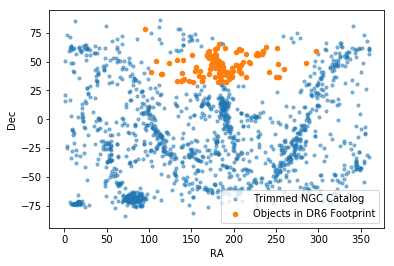

In [30]:
qa_sample()

### Generate the color mosaics for each object.

In [31]:
def custom_brickname(obj, prefix='custom-'): 
    brickname = 'custom-{:06d}{}{:05d}'.format(
        int(1000*obj['ra']), 'm' if obj['dec'] < 0 else 'p', 
        int(1000*np.abs(obj['dec'])))
    return brickname

In [32]:
def get_factor(objtype):
    """Scale factors for the mosaics."""
    ref = dict(
        G = 2,
        GCl = 2,
        OCl = 2,
        PN = 4,
    )
    return ref[objtype]

In [33]:
def make_coadds_one(obj, scale=PIXSCALE, clobber=False):
    name = get_name(obj)
    jpgfile = os.path.join(jpgdir, '{}.jpg'.format(name))
    if os.path.isfile(jpgfile) and not clobber:
        print('File {} exists...skipping.'.format(jpgfile))
    else:
        factor = get_factor(obj['type'])
        diam = factor * ma.getdata(obj['majax']) * 60.0 # diameter [arcsec]
        
        size = np.rint(diam / scale).astype('int') # [pixels]
        print('Generating mosaic for {} (type={}) with width={} pixels.'.format(name, obj['type'], size))
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            run_brick(None, survey, radec=(obj['ra'], obj['dec']), pixscale=scale, 
                      width=size, height=size, stages=['image_coadds'], splinesky=True,
                      early_coadds=True, pixPsf=True, hybridPsf=True, normalizePsf=True,
                      write_pickles=False, depth_cut=False, apodize=True, threads=nproc,
                      do_calibs=False, ceres=False)
            
        sys.stdout.flush()    
        brickname = custom_brickname(obj, prefix='custom-')
        _jpgfile = os.path.join(survey.output_dir, 'coadd', 'cus', brickname, 
                               'legacysurvey-{}-image.jpg'.format(brickname))
        shutil.copy(_jpgfile, jpgfile)
        shutil.rmtree(os.path.join(survey.output_dir, 'coadd'))

In [34]:
def make_coadds(sample, clobber=False):
    for obj in sample:
        make_coadds_one(obj, clobber=clobber)

In [35]:
#make_coadds_one(sample[111], clobber=True)

In [36]:
coaddslogfile = os.path.join(gallerydir, 'make-coadds.log')
print('Generating the coadds.')
print('Logging to {}'.format(coaddslogfile))
t0 = time.time()
with open(coaddslogfile, 'w') as log:
    with redirect_stdout(log):
        make_coadds(sample, clobber=False)
print('Total time = {:.3f} minutes.'.format((time.time() - t0) / 60))

Generating the coadds.
Logging to /global/cscratch1/sd/ioannis/dr6/gallery/make-coadds.log
Total time = 5.100 minutes.


### Add labels and a scale bar.

In [37]:
barlen = np.round(60.0 / PIXSCALE).astype('int')
fonttype = os.path.join(gallerydir, 'Georgia.ttf')

In [38]:
def _add_labels_one(args):
    """Wrapper function for the multiprocessing."""
    return add_labels_one(*args)

In [39]:
def add_labels_one(obj, verbose=False):
    name = get_name(obj)
    nicename = get_name(obj, nice=True)
    
    jpgfile = os.path.join(jpgdir, '{}.jpg'.format(name))
    pngfile = os.path.join(pngdir, '{}.png'.format(name))
    thumbfile = os.path.join(pngdir, 'thumb-{}.png'.format(name))
        
    im = Image.open(jpgfile)
    sz = im.size
    fntsize = np.round(sz[0]/28).astype('int')
    width = np.round(sz[0]/175).astype('int')
    font = ImageFont.truetype(fonttype, size=fntsize)
    draw = ImageDraw.Draw(im)
    # Label the object name--
    draw.text((0+fntsize*2, 0+fntsize*2), nicename, font=font)
    # Add a scale bar--
    x0, x1, yy = sz[1]-fntsize*2-barlen, sz[1]-fntsize*2, sz[0]-fntsize*2
    draw.line((x0, yy, x1, yy), fill='white', width=width)
    im.save(pngfile)    
        
    # Generate a thumbnail
    cmd = '/usr/bin/convert -thumbnail 300x300 {} {}'.format(pngfile, thumbfile)
    os.system(cmd)

In [40]:
def add_labels(sample):
    labelargs = list()
    for obj in sample:
        labelargs.append((obj, False))

    if nproc > 1:
        p = multiprocessing.Pool(nproc)
        res = p.map(_add_labels_one, labelargs)
        p.close()
    else:
        for args in labelargs:
            res = _add_labels_one(args)

In [41]:
%time add_labels(sample)

CPU times: user 319 ms, sys: 1.08 s, total: 1.4 s
Wall time: 32.6 s


### Finally, assemble the webpage of good and rejected gallery images.

To test the webpage before release, do
  * rsync -auvP /global/cscratch1/sd/ioannis/dr6/gallery/png /global/project/projectdirs/cosmo/www/temp/ioannis/dr6/gallery/
  * rsync -auvP /global/cscratch1/sd/ioannis/dr6/gallery/*.html /global/project/projectdirs/cosmo/www/temp/ioannis/dr6/gallery/

In [42]:
def get_type(hubble):
    """Convert Hubble type to numerical type, for sorting purposes."""
    numtype = {
        'E': 0,
        'E-S0': 1,
        
        'S0': 2,
        'S0-a': 3,
        
        'Sa': 4,
        'SBa': 4,
        'SABa': 4,

        'Sab': 5,
        'SBab': 5,
        
        'Sb': 6,
        'SABb': 6,
        'SBb': 6,

        'Sbc': 7,
        
        'Sc': 8,
        'SABc': 8,
        'SBc': 8,
        
        'Scd': 9,
        'SBcd': 9,
        
        'Sd': 10,
        
        'Sm': 11,
        'SBm': 11,
        
        'I': 12,
        'IAB': 12,
        'IB': 12,
        
        '0': -1
    }
    return np.array([numtype[hh] for hh in hubble])

In [43]:
reject = ['ngc3587', 'ngc6832', 'ngc5982', 'ngc2832', 'ngc2340', 'ngc5195',
          'ngc5308', 'ngc4346', 'ngc4036', 'ngc2681', 'ngc3718', 'ngc5377',
          'ngc2146', 'ngc3126', 'ngc2841', 'ngc2683', 'ngc4217', 'ngc4357',
          'ngc5055', 'ngc4100', 'ngc5879', 'ngc5297', 'ngc4605', 'ngc6015',
          'ngc4144', 'ngc3733', 'ngc3079', 'ngc3198', 'ngc3430', 'ngc3877',
          'ngc4062', 'ngc4631', 'ngc4656_ned01', 'ngc4395']
toss = np.zeros(len(sample), dtype=bool)
name = get_name(sample)
for ii, nn in enumerate(name):
    for rej in np.atleast_1d(reject):
        toss[ii] = rej in nn.lower()
        if toss[ii]:
            break
print('Rejecting {} objects.'.format(np.sum(toss)))
pngkeep = sample[~toss]
if np.sum(toss) > 0:
    pngrej = sample[toss]
else:
    pngrej = []

Rejecting 34 objects.


In [44]:
htmlfile = os.path.join(gallerydir, 'index.html')
htmlfile_reject = os.path.join(gallerydir, 'index-reject.html')
baseurl = 'http://legacysurvey.org/viewer-dev'

In [59]:
def html_rows(pngkeep, nperrow=4):
    nrow = np.ceil(len(pngkeep) / nperrow).astype('int')
    pngsplit = list()
    for ii in range(nrow):
        i1 = nperrow*ii
        i2 = nperrow*(ii+1)
        if i2 > len(pngkeep):
            i2 = len(pngkeep)
        pngsplit.append(pngkeep[i1:i2])
    #pngsplit = np.array_split(pngkeep, nrow)
    print('Splitting the sample into {} rows with {} mosaics per row.'.format(nrow, nperrow))

    html.write('<table class="ls-gallery">\n')
    html.write('<tbody>\n')
    for pngrow in pngsplit:
        html.write('<tr>\n')
        for obj in pngrow:
            name = get_name(obj)
            nicename = get_name(obj, nice=True)
            pngfile = os.path.join('png', '{}.png'.format(name))
            thumbfile = os.path.join('png', 'thumb-{}.png'.format(name))
            img = 'src="{}" alt="{}"'.format(thumbfile, nicename)
            #img = 'class="ls-gallery" src="{}" alt="{}"'.format(thumbfile, nicename)
            html.write('<td><a href="{}"><img {}></a></td>\n'.format(pngfile, img))
        html.write('</tr>\n')
        html.write('<tr>\n')
        for obj in pngrow:
            nicename = get_name(obj, nice=True)
            href = '{}/?layer=decals-{}&ra={:.8f}&dec={:.8f}&zoom=12'.format(baseurl, dr, obj['ra'], obj['dec'])
            html.write('<td><a href="{}" target="_blank">{}</a></td>\n'.format(href, nicename))
        html.write('</tr>\n')
    html.write('</tbody>\n')            
    html.write('</table>\n')

In [60]:
objtype = ma.getdata(pngkeep['type'])
hubbletype = get_type(ma.getdata(pngkeep['hubble']))

In [63]:
with open(htmlfile, 'w') as html:
    html.write('<html><head>\n')
    html.write('<style type="text/css">\n')
    html.write('table.ls-gallery {width: 90%;}\n')
    #html.write('img.ls-gallery {display: block;}\n')
    #html.write('td.ls-gallery {width: 100%; height: auto}\n')
    #html.write('td.ls-gallery {width: 100%; word-wrap: break-word;}\n')
    html.write('p.ls-gallery {width: 80%;}\n')
    html.write('</style>\n')
    html.write('</head><body>\n')
    html.write('<h1>DR6 Image Gallery</h1>\n')
    html.write("""<p class="ls-gallery">This gallery highlights the exquisite image quality and diversity 
    of objects observed by the Legacy Survey, including planetary nebulae, globular clusters, and 
    large, nearby galaxies.  Each thumbnail links to a larger image while the object name below each 
    thumbnail links to the 
    <a href="http://legacysurvey.org/viewer">Sky Viewer</a>.  For reference, the horizontal white bar in 
    the lower-right corner of each image represents one arcminute.</p>\n""")
    html.write("""<p>We gratefully acknowledge the <a href="https://github.com/mattiaverga/OpenNGC" target="_blank">
    OpenNGC</a> catalog created by Mattia Verga, which was used to generate this sample.</p>\n""")
    html.write("""<p>For more eye candy, please visit the gallery of galaxy groups highlighted in the 
    <a href="http://portal.nersc.gov/project/cosmo/data/legacysurvey/dr5/gallery/">DR5 Gallery.</a></p>\n""")
    
    # Split by object type
    
    html.write('<h2>Planetary Nebulae, Open Clusters, and Globular Clusters</h2>\n')
    these = np.logical_or( np.logical_or(objtype == 'PN', objtype == 'OCl'), objtype == 'GCl' )
    srt = np.argsort(objtype[these])[::-1]
    html_rows(pngkeep[these][srt])
    html.write('<br />\n')
    
    html.write('<h2>Spheroidal & Elliptical Galaxies</h2>\n')
    these = (objtype == 'G') * (hubbletype <= 2)
    srt = np.argsort(hubbletype[these])
    html_rows(pngkeep[these][srt])

    html.write('<h2>Early-Type Disk Galaxies</h2>\n')
    these = (objtype == 'G') * (hubbletype >= 3) * (hubbletype <= 6)
    srt = np.argsort(hubbletype[these])
    html_rows(pngkeep[these][srt])

    html.write('<h2>Late-Type Disk Galaxies</h2>\n')
    these = (objtype == 'G') * (hubbletype >= 7) * (hubbletype <= 10)
    srt = np.argsort(hubbletype[these])
    html_rows(pngkeep[these][srt])
    
    html.write('<h2>Irregular Galaxies</h2>\n')
    these = (objtype == 'G') * (hubbletype >= 11)
    srt = np.argsort(hubbletype[these])
    html_rows(pngkeep[these][srt])
    
    html.write('</body></html>\n')

Splitting the sample into 2 rows with 4 mosaics per row.
Splitting the sample into 3 rows with 4 mosaics per row.
Splitting the sample into 7 rows with 4 mosaics per row.
Splitting the sample into 9 rows with 4 mosaics per row.
Splitting the sample into 3 rows with 4 mosaics per row.


In [48]:
if len(pngrej) > 0:
    with open(htmlfile_reject, 'w') as html:
        html.write('<html><head>\n')
        html.write('<style type="text/css">\n')
        html.write('img.ls-gallery {display: block;}\n')
        html.write('td.ls-gallery {width: 20%; word-wrap: break-word;}\n')
        html.write('</style>\n')
        html.write('</head><body>\n')
        html.write('<h1>DR6 Image Gallery - Rejected</h1>\n')
        html_rows(pngrej)
        html.write('</body></html>\n')

Splitting the sample into 7 rows with 5 mosaics per row.
